In [34]:
first_time_importing_torch = True
first_time_importing_torchvision = True

In [36]:
import time
# NOTE: Importing torch the first time will always take a long time!
if first_time_importing_torch:
    print(f"Importing torch ...")
    import_torch_start_time = time.time() 
import torch
if first_time_importing_torch:
    import_torch_end_time = time.time()
    print(f"Importing torch took {import_torch_end_time - import_torch_start_time} seconds")
    first_time_importing_torch = False

if first_time_importing_torchvision:
    print(f"Importing torchvision ...")
    import_torchvision_start_time = time.time()
import torchvision
if first_time_importing_torchvision:
    import_torchvision_end_time = time.time()
    print(f"Importing torchvision took {import_torchvision_end_time - import_torchvision_start_time} seconds")
    first_time_importing_torchvision = False

from torchvision import transforms

import os
from tqdm import tqdm
import numpy as np

from PIL import Image

import matplotlib.pyplot as plt

In [14]:
CHEST_XRAY_BASE_DATA_PATH = "../data/chest_xray"

In [15]:
# TODO: CHANGE THIS TO YOUR PATH
# NOTE: Windows uses \\ instead of /
def load_images_chest_xray(data_path: str, ids: list) -> list:
    files = os.listdir(data_path)
    jpeg_files = [f for f in files if f.endswith(".jpeg")]

    images = []
    for id in tqdm(ids):
        if id >= len(jpeg_files): continue
        # print(f"Loading image {id} from {data_path}")
        image = Image.open(os.path.join(data_path, jpeg_files[id]))
        images.append(image)
    
    return images

100%|██████████| 1/1 [00:00<00:00, 37.29it/s]


(1857, 1317)


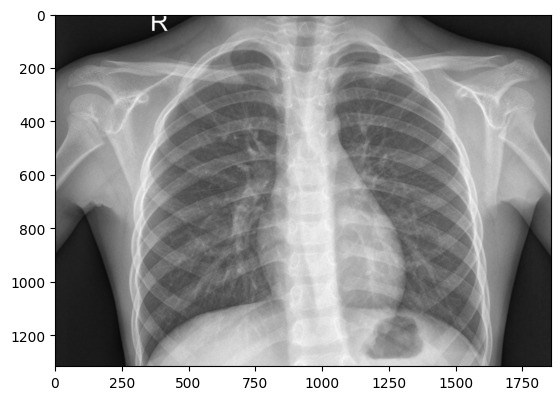

In [16]:
def test_load_images_chest_xray(stage="test", label="NORMAL"):
    for img in load_images_chest_xray(f"{CHEST_XRAY_BASE_DATA_PATH}/{stage}/{label}", [0]):
        print(img.size)
        plt.imshow(img, cmap='gray')
    plt.show();

test_load_images_chest_xray()

In [87]:
DEVICE = "cuda"

torch.set_default_device(DEVICE)

PIL_to_tensor = transforms.PILToTensor(
)

tensor_to_PIL = transforms.ToPILImage(
    mode="L"
)
# From docstring:     Converts a torch.*Tensor of shape C x H x W or a numpy ndarray of shape
# H x W x C to a PIL Image while adjusting the value range depending on the ``mode``.
# Args:
#     mode (`PIL.Image mode`_): color space and pixel depth of input data (optional).
#         If ``mode`` is ``None`` (default) there are some assumptions made about the input data:
#         - If the input has 4 channels, the ``mode`` is assumed to be ``RGBA``.
#         - If the input has 3 channels, the ``mode`` is assumed to be ``RGB``.
#         - If the input has 2 channels, the ``mode`` is assumed to be ``LA`` (L with alpha). 
#         - If the input has 1 channel, the ``mode`` is determined by the data type (i.e ``int``, ``float``, ``short``).
# .. _PIL.Image mode: https://pillow.readthedocs.io/en/latest/handbook/concepts.html#concept-modes


# # Define a transform to convert PIL image to a Torch tensor 
# transform_ = transforms.Compose([ 
#     transforms.PILToTensor(),
# ])
# transform = transforms.PILToTensor() 
# Convert the PIL image to Torch tensor 
# img_tensor = transform(image) 
  


def get_variable_noise(sigma_min, sigma_max):
    return sigma_min + torch.rand(1) * (sigma_max - sigma_min)

def add_noise(xf: torch.tensor, sigma) -> torch.tensor:
    std = torch.std(xf)
    mu = torch.mean(xf)

    x_centred = (xf  - mu) / std

    x_centred += sigma * torch.randn(xf.shape, dtype = xf.dtype)

    xnoise = std * x_centred + mu

    del std, mu, x_centred

    return xnoise


def tensor_2d_to_image(tensor_2d: torch.tensor) -> Image:
    tensor_2d_np = tensor_2d.to("cpu").detach().numpy()
    tensor_2d_np_int = (tensor_2d_np * 255.0).clip(0, 255.0).astype(np.uint8)
    print(f"type(tensor_2d_np_int) = {type(tensor_2d_np_int)}")
    print(f"shape: {tensor_2d_np_int.shape}")
    image = Image.fromarray(tensor_2d_np_int)
    return image


def get_noisy_image(rgb: Image, sigma) -> Image:
    # im_2d = torch.tensor(np.array(rgb)) / 255.0

    im_2d = PIL_to_tensor(rgb).to(DEVICE).squeeze(0) / 255.0

    # max_value = torch.max(im_2d)
    # min_value = torch.min(im_2d)
    # print(f"max_value = {max_value}, min_value = {min_value}")
    # assert max_value <= 1.0 and min_value >= 0.0


    noisy_2d = add_noise(im_2d, sigma=sigma)

    # noisy_im_v1 = tensor_2d_to_image(noisy_2d)

    noisy_2d = torch.clamp((noisy_2d * 255).unsqueeze(0), 0, 255).to(torch.uint8)
    noisy_im_v2 = tensor_to_PIL(noisy_2d) 

    # plt.imshow(noisy_im_v1, cmap='gray')
    # plt.title(f"v1")
    # plt.show();
    # plt.imshow(noisy_im_v2, cmap='gray')
    # plt.title(f"v2")
    # plt.show();

    # return noisy_im_v1
    return noisy_im_v2

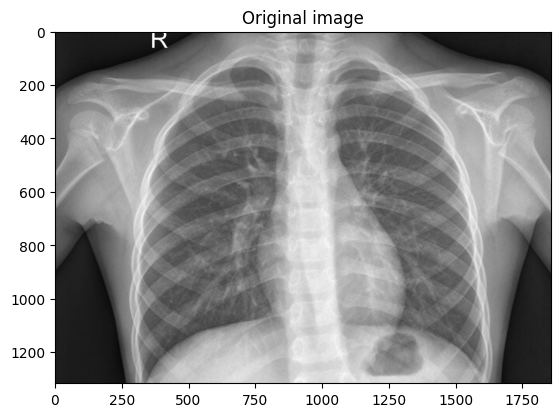

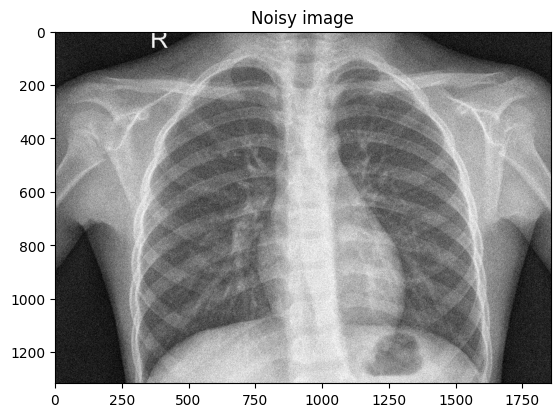

In [88]:
def test_gen_noisy_images():
    # img = load_images_chest_xray(f"{CHEST_XRAY_BASE_DATA_PATH}/test/NORMAL", [0])[0]
    img = Image.open("../data/chest_xray/test/NORMAL/IM-0001-0001.jpeg")
    plt.imshow(img, cmap='gray')
    plt.title("Original image")
    plt.show();
    
    noisy_img = get_noisy_image(img, 0.5)
    plt.imshow(noisy_img, cmap='gray')
    plt.title("Noisy image")
    plt.show();

test_gen_noisy_images()

In [50]:
def gen_noisy_images_for_sigma(data_path, subfolder, label, files, output_path, sigma, overwrite=False):
    for file in tqdm(files):
        output_file = f"{output_path}/{file}"
        if not overwrite and os.path.exists(output_file):
            continue

        img = Image.open(f"{data_path}/{subfolder}/{label}/{file}")
        noisy_img = get_noisy_image(img, sigma)
        noisy_img.save(output_file)


def gen_noisy_images(subfolders, labels, sigmas, overwrite=False):
    chest_xray_data_path = f"../data/chest_xray"
    for subfolder in subfolders:
        for label in labels:
            files = os.listdir(f"{chest_xray_data_path}/{subfolder}/{label}")
            for sigma in sigmas:
                sigma = round(sigma, 1)
                print(f"Generating noisy images for {subfolder}/{label} with sigma={sigma} (overwrite={overwrite})")
                sigma_str = str(sigma).replace(".", "_")
                output_path = f"{chest_xray_data_path}/{subfolder}/{label}_noisy_{sigma_str}"
                os.makedirs(output_path, exist_ok=True)
                gen_noisy_images_for_sigma(chest_xray_data_path, subfolder, label, files, output_path, sigma, overwrite=overwrite)

In [32]:
gen_noisy_images(["val"], ["PNEUMONIA"], np.linspace(0.1, 1.0, 10), overwrite=False)


Generating noisy images for train/NORMAL with sigma=0.1 (overwrite=False)


  0%|          | 0/1341 [00:00<?, ?it/s]

100%|██████████| 1341/1341 [00:02<00:00, 611.45it/s]


Generating noisy images for train/NORMAL with sigma=0.2 (overwrite=False)


100%|██████████| 1341/1341 [01:01<00:00, 21.88it/s]


Generating noisy images for train/NORMAL with sigma=0.3 (overwrite=False)


100%|██████████| 1341/1341 [00:01<00:00, 912.96it/s]


Generating noisy images for train/NORMAL with sigma=0.4 (overwrite=False)


100%|██████████| 1341/1341 [01:01<00:00, 21.91it/s]


Generating noisy images for train/NORMAL with sigma=0.5 (overwrite=False)


100%|██████████| 1341/1341 [00:01<00:00, 939.86it/s]


Generating noisy images for train/NORMAL with sigma=0.6 (overwrite=False)


100%|██████████| 1341/1341 [01:03<00:00, 21.26it/s]


Generating noisy images for train/NORMAL with sigma=0.7 (overwrite=False)


100%|██████████| 1341/1341 [01:03<00:00, 21.23it/s]


Generating noisy images for train/NORMAL with sigma=0.8 (overwrite=False)


100%|██████████| 1341/1341 [01:03<00:00, 21.08it/s]


Generating noisy images for train/NORMAL with sigma=0.9 (overwrite=False)


100%|██████████| 1341/1341 [01:04<00:00, 20.81it/s]


Generating noisy images for train/NORMAL with sigma=1.0 (overwrite=False)


100%|██████████| 1341/1341 [01:04<00:00, 20.91it/s]


In [33]:
print("hello")

hello
